In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math

import mnist

In [3]:
train_data, test_data = mnist.fetch_mnist()

loss=0.19, acc=0.937500: 100%|██████████| 1000/1000 [00:01<00:00, 587.96it/s]


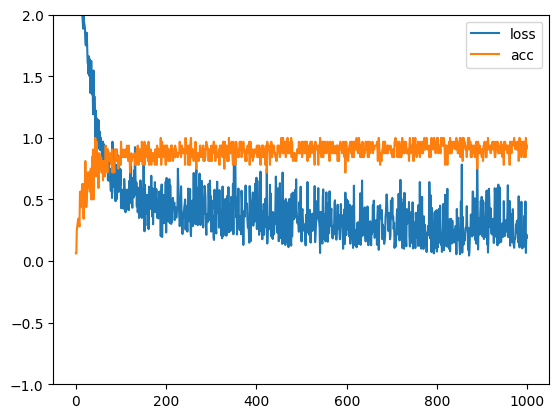

In [4]:
def plot_losses_and_acc(losses, accuracies):
    plt.ylim(-1, 2)
    plt.plot(losses)
    plt.plot(accuracies)
    plt.legend(labels=['loss', 'acc'])

model, stats = mnist.torch_train(*train_data)
plot_losses_and_acc(*stats)

In [5]:
torch_acc = mnist.torch_eval(*test_data, model).item()
torch_acc

0.929099977016449

In [6]:
# copy model from pytorch to numpy
torch_l1 = np.zeros((28*28, 128), dtype=np.float32)
torch_l2 = np.zeros((128, 10), dtype=np.float32)
torch_l1[:] = model.l1.weight.detach().numpy().transpose()
torch_l2[:] = model.l2.weight.detach().numpy().transpose()

In [7]:
# now we have the same weights in numpy arrays
# we can test whether our forward pass works by checking on the accuarcy

smol_acc = mnist.smol_eval(*test_data, (torch_l1, torch_l2))

if math.isclose(torch_acc, smol_acc, abs_tol=1e-4):
    print('accuracy matches!')

smol_acc, torch_acc

accuracy matches!


(0.9291, 0.929099977016449)

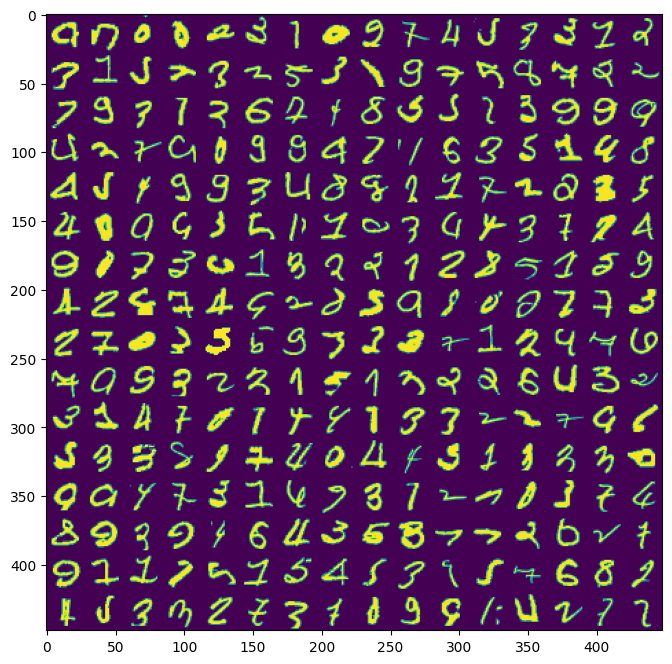

In [8]:
def smol_loss(X, Y):
    X = X.reshape((-1, 28*28))
    out = mnist.smol_forward(X, torch_l1, torch_l2)
    pred = out.argmax(axis=1)
    loss = -out[range(out.shape[0]), Y]

    return loss

def show_cursed_digits(X, loss):
    G = 16
    messup = sorted(zip(loss, range(X.shape[0])), key=lambda x: x[0], reverse=True)
    X_bad = X[[x[1] for x in messup[:G*G]]]
    plt.figure(figsize=(8,8))
    imshow(np.concatenate(X_bad.reshape((G, 28 * G, 28)), axis=1))

show_cursed_digits(train_data[0], smol_loss(*train_data))

tensor(0.0566, grad_fn=<NllLossBackward0>)
loss.grad = tensor(1.)
x_lsm.grad = tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]])
x_l2.grad = tensor([[ 1.6829e-03,  8.2039e-05,  2.3056e-03,  4.7941e-02,  4.7333e-07,
         -5.3313e-02,  3.9291e-05,  1.8418e-04,  8.8684e-04,  1.9038e-04],
        [-2.4813e-04,  1.2981e-08,  4.3553e-05,  1.8987e-05,  7.0035e-09,
          1.7014e-04,  3.9719e-06,  2.6089e-06,  6.1155e-06,  2.6568e-06]])


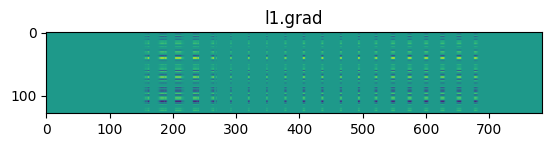

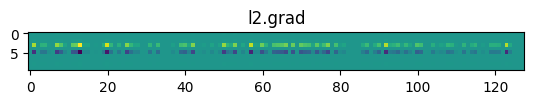

In [9]:
# backward, pytorch reference
import torch
from torch import tensor
import torch.nn.functional as F

def torch_backward():
    model.zero_grad()

    X_train, Y_train = train_data

    # forward
    x = tensor(X_train[0:2].reshape((-1, 28*28)))
    x_l1 = model.l1(x)
    x_relu = F.relu(x_l1)
    x_l2 = model.l2(x_relu)
    x_lsm = F.log_softmax(x_l2, dim=1)
    loss = F.nll_loss(x_lsm, tensor(Y_train[0:2]))
    print(loss)

    x_l1.retain_grad()
    x_relu.retain_grad()
    x_l2.retain_grad()
    x_lsm.retain_grad()
    loss.retain_grad()

    # backward
    loss.backward()

    print('loss.grad =', loss.grad)
    print('x_lsm.grad =', x_lsm.grad)
    print('x_l2.grad =', x_l2.grad)
    #print('x_relu.grad =', x_relu.grad)
    #print('x_l1.grad =', x_l1.grad)

    plt.figure()
    plt.title("l1.grad")
    imshow(model.l1.weight.grad)

    plt.figure()
    plt.title("l2.grad")
    imshow(model.l2.weight.grad)

torch_backward()

loss=0.260311, acc=0.937500: 100%|██████████| 1000/1000 [00:17<00:00, 56.34it/s]


0.9245

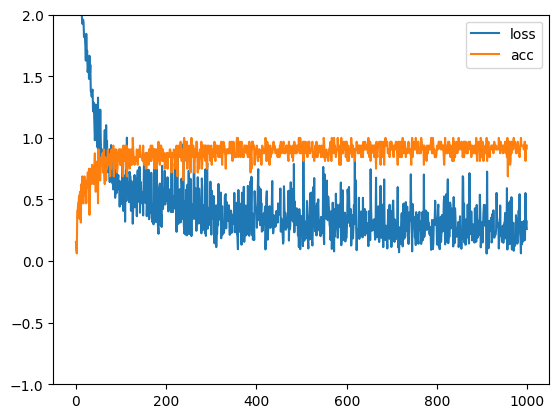

In [10]:
# backward, ours

weights, stats = mnist.smol_train(*train_data)
plot_losses_and_acc(*stats)
mnist.smol_eval(*test_data, weights)